## LDA topic modeling
We use Latent Dirichlet Allocation (LDA) as topic model to extract topics of the plain text dataset, and more importantly obtain the topis distribution within each article. With topic distribution information, we can clearly see the changes in topic within the clicking path. Most intuitively, people may try to find the relation between the two articles and the article topic would become closer and closer to the target article’s topic as the click process goes on. For example when navigating from ‘Zebra’ to ‘French Revolution’, the elements of animals may decrease and the elements of history or politics may increase through the path.

In [1]:
# LDA
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import CoherenceModel
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
import pyLDAvis.gensim_models
from pprint import pprint

/Users/wayer/opt/miniconda3/lib/python3.9/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(
/Users/wayer/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [15]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from imp import reload

## LDA text preprocess
Our LDA model is generated from the 'plaintext_articles' dataset. Necessary functions are listed below.

In [12]:
def load_plaintext():
    """
    Load txt files from 'plaintext_articles' folder with alphabetical order.
    Delete copyright and source info.
    """
    path = 'plaintext_articles'
    files = os.listdir(path)
    files.sort(key=lambda x:str(x.split('.')[0]).lower())
    texts = []
    for i, file in enumerate(files):
        if os.path.splitext(file)[1] == '.txt':
            file_path = os.path.join(path, file)
            with open(file_path, "r", encoding='utf-8') as f:
                txt = [line.strip() for line in f.readlines()]
                del txt[-5:-1]  #retrieved info
                del txt[0]      #copyright line
                try:
                    texts.append(txt)
                except Exception as e:
                    print(e)
    print("Finish loading plaintext.")
    return texts


def sent_to_words(sentences):
    """
    For each article, split words from sentences and remove digits.
    """
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
    print("Finish transforming sentences to words.")

    
def clean_digit_short(texts):
    """
    Remove numbers and one character words
    """
    texts = [[token for token in doc if not token.isdigit()] for doc in texts]
    texts = [[token for token in doc if len(token) > 3] for doc in texts]
    print("Finish cleaning digits and short words.")
    return texts


def form_bigrams(texts):
    """
    Form bigrams with at least 5 counts.
    """
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100.0)
    print("Finish creating bigrams.")
    return [bigram[doc] for doc in texts], bigram


def remove_stopwords(texts):
    """
    Remove stopwords.
    """
    stopwords = nlp.Defaults.stop_words
    stopwords |= {'january', 'february', 'april', 'may', 'june', 'july', 'august', 'september',\
                  'october', 'november', 'december', 'monday', 'tuesday', 'wednesday', 'thursday',\
                  'friday', 'saturday', 'sunday'}
    print("Finish removing stop words.")    
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stopwords] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN']):
    """
    Do lemmatization and only keep nouns.
    """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    print("Finish lemmatization.")
    return texts_out


def lda_preprocess():
    """
    Call data preparation functions.
    Create dictionary and corpus.
    """
    data = load_plaintext()
    data_words = list(sent_to_words(data))
    data_words = clean_digit_short(data_words)
    data_words = remove_stopwords(data_words)
    data_words = form_bigrams(data_words)[0]
    data_words = lemmatization(data_words, allowed_postags=['NOUN'])

    id2word = corpora.Dictionary(data_words)
    id2word.filter_extremes(no_below=5, no_above=0.5)

    corpus = [id2word.doc2bow(text) for text in data_words]
    return data_words, id2word, corpus

To determain the best number of topic in LDA model, we use 2 metrics: coherence score (c_v) and self-defined function: topic diversity, which gives us the proportion of unique words. <br>
We can first find an approximate interval where the best number of topics lies, then do fine-tuning.

In [4]:
def topic_diversity(lda_model, t):
    """
    Calculate topic diversity score.
    Score = proportion of unique words
    """
    topics = str(lda_model.print_topics(t))
    topics = re.sub(r'\W|1|2|3|4|5|6|7|8|9', "", topics)
    topics = re.sub(r'0', " ", topics)
    topiclist = topics.split(' ')
    topiclist = [x for x in topiclist if x != '']
    topicset = set(topiclist)
    diversity_score = len(topicset)/len(topiclist)
    return diversity_score

In [40]:
def lda_param_tune():
    num_topics = [5, 10, 15, 20, 25]
    lda_models = []
    for n in num_topics:
        lda_model = gensim.models.LdaModel(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=n, 
                                    random_state=42,
                                    passes = 10)
        lda_models.append(lda_model)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, \
                          dictionary=id2word, coherence='c_v')
        coherence_score = '%.4f'%coherence_model_lda.get_coherence()
        diversity_score = '%.4f'%topic_diversity(lda_model, n)
        comprehensive_score = float(coherence_score) * float(diversity_score)
        print("number of topics", n, "coherence_score :", coherence_score, "diversity_score: ", diversity_score,
             "comprehensive score :", '%.4f'%comprehensive_score)
    return lda_models
        
def lda_param_finetune(start, end):
    lda_models = []
    for n in range(start, end):
        lda_model = gensim.models.LdaModel(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=n, 
                                    random_state=42,
                                    passes = 10)
        lda_models.append(lda_model)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, \
                          dictionary=id2word, coherence='c_v')
        coherence_score = '%.4f'%coherence_model_lda.get_coherence()
        diversity_score = '%.4f'%topic_diversity(lda_model, n)
        comprehensive_score = float(coherence_score) * float(diversity_score)
        print("number of topics", n, "coherence_score :", coherence_score, "diversity_score: ", diversity_score,
             "comprehensive score :", '%.4f'%comprehensive_score)
    return lda_models

In [42]:
data_words, id2word, corpus = lda_preprocess()

Finish loading plaintext.
Finish transforming sentences to words.
Finish cleaning digits and short words.
Finish removing stop words.
Finish creating bigrams.
Finish lemmatization.


In [16]:
lda_param_tune()

number of topics 5 coherence_value : 0.4671 diversity_score:  0.9400
number of topics 10 coherence_value : 0.5456 diversity_score:  0.9400
number of topics 15 coherence_value : 0.5713 diversity_score:  0.8933
number of topics 20 coherence_value : 0.6017 diversity_score:  0.8600
number of topics 25 coherence_value : 0.5941 diversity_score:  0.8240
number of topics 30 coherence_value : 0.5653 diversity_score:  0.8033


Consider both coherence and diversity score, the approximate interval is between 5 and 20. We can do fine tune now to get the best topic number.

In [19]:
lda_param_finetune(10, 20)

number of topics 10 coherence_value : 0.5456 diversity_score:  0.9400
number of topics 11 coherence_value : 0.5428 diversity_score:  0.8545
number of topics 12 coherence_value : 0.5704 diversity_score:  0.8750
number of topics 13 coherence_value : 0.5691 diversity_score:  0.8923
number of topics 14 coherence_value : 0.5727 diversity_score:  0.9071
number of topics 15 coherence_value : 0.5713 diversity_score:  0.8933
number of topics 16 coherence_value : 0.6012 diversity_score:  0.9062
number of topics 17 coherence_value : 0.5985 diversity_score:  0.9000
number of topics 18 coherence_value : 0.6006 diversity_score:  0.8444
number of topics 19 coherence_value : 0.6105 diversity_score:  0.8526


Now we get our best parameter: there are 16 topics in our dataset. We can see top words in the final LDA model and also visualize the LDA model.

In [22]:
#lda_model = lda_models[6]
lda_model = gensim.models.LdaModel(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=16, 
                                    random_state=42,
                                    passes = 10)
pprint(lda_model.print_topics())

[(0,
  '0.043*"music" + 0.029*"song" + 0.026*"band" + 0.022*"album" + '
  '0.011*"record" + 0.011*"style" + 0.008*"tour" + 0.007*"instrument" + '
  '0.007*"sound" + 0.007*"opera"'),
 (1,
  '0.020*"earth" + 0.013*"system" + 0.013*"planet" + 0.013*"energy" + '
  '0.010*"space" + 0.010*"temperature" + 0.010*"surface" + 0.009*"star" + '
  '0.007*"point" + 0.007*"distance"'),
 (2,
  '0.034*"player" + 0.029*"team" + 0.020*"game" + 0.015*"ball" + '
  '0.010*"flight" + 0.009*"event" + 0.009*"sport" + 0.009*"season" + '
  '0.008*"engine" + 0.008*"championship"'),
 (3,
  '0.049*"city" + 0.012*"building" + 0.011*"line" + 0.010*"town" + '
  '0.009*"station" + 0.009*"school" + 0.009*"park" + 0.009*"centre" + '
  '0.008*"service" + 0.008*"university"'),
 (4,
  '0.024*"work" + 0.019*"book" + 0.009*"artist" + 0.009*"painting" + '
  '0.008*"poet" + 0.007*"poem" + 0.007*"pound" + 0.007*"line" + 0.006*"novel" '
  '+ 0.006*"style"'),
 (5,
  '0.030*"film" + 0.018*"character" + 0.013*"story" + 0.013*"series

We can manually give each topic a name.

In [43]:
topics = ['Music', 'Space and Cosmos', 'Sports', 'Urban Construction', 'Literature', 'Movie',
         'Social Study', 'Electronics Industry', 'Health', 'Information Technology', 'Chemical Processes',
         'Government Affairs', 'Religion', 'Military', 'Political Campaign', 'Nature']

In [23]:
model_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(model_data)

/Users/wayer/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/wayer/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/wayer/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/wayer/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/wayer/opt/miniconda3/lib/python3.9/site-packages/past/builtins/mi

We can now visualize the changes in topic within a path.

In [56]:
df = pd.DataFrame()
df['topics'] = lda_model.get_document_topics(corpus)
sf = pd.DataFrame(data=df['topics'])
af = pd.DataFrame()
for i in range(16):
    af[str(i)]=[]
frames = [sf,af]
af = pd.concat(frames).fillna(0)
for i in range(4604):
    for j in range(len(df['topics'][i])):
        af[str(df['topics'][i][j][0])].loc[i] = df['topics'][i][j][1]
af.drop('topics', axis=1, inplace=True)
af.columns = topics

In [62]:
def topic_change_vis(path):
    """
    Given a list of articles, visualize the changes in topic.
    """
    tdf = af.iloc[path]
    tdf.reset_index(drop=True, inplace=True)
    tdf.plot(kind='area') 

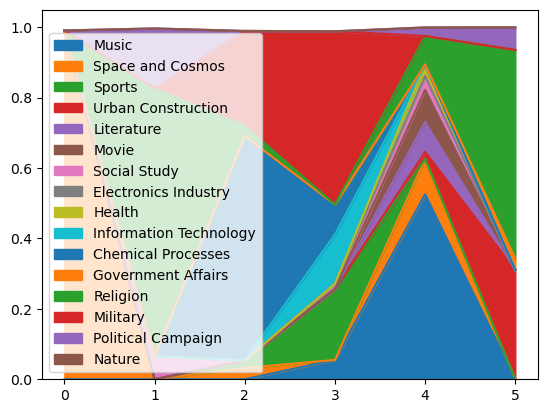

In [63]:
path = [13, 894, 1820, 1511, 1822, 2847]
topic_change_vis(path)